In [380]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.optim.lr_scheduler import StepLR

from torch.autograd import Variable
from utils import create_dataloader

import matplotlib.pyplot as plt
%matplotlib inline

In [381]:
torch.cuda.set_device(0)

### Creating config object (argparse workaround)

In [382]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 100
config.print_freq = 200
config.image_size = 28

torch.cuda.set_device(2)

### Create noise

In [383]:
def make_noise(batch_size, noise_size, requires_grad=False):
    return Variable(torch.FloatTensor(batch_size, noise_size).normal_(0, 1), requires_grad=requires_grad).cuda()

### Plot samples from generator

In [384]:
def plot_samples(generator, n_objects, figsize=(5,5)):
    X = generator(make_noise(n_objects[0] * n_objects[1], config.noise_size)).data.cpu().numpy()
    plt.figure(figsize=figsize)
    for i in range(n_objects[0] * n_objects[1]):
        plt.subplot(n_objects[0], n_objects[1], i+1)
        plt.imshow(X[i].reshape(config.image_size, config.image_size), cmap=plt.cm.Greys_r)
        plt.axis('off')
    plt.show()

### Create dataloder

In [385]:
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST


def create_dataloader(config, dataset=None):
    if dataset is not None:
        return DataLoader(dataset=dataset, batch_size=config.batch_size, 
                          shuffle=True, num_workers=config.num_workers)

    transform = transforms.Compose([transforms.Resize(config.image_size), transforms.ToTensor()])
    if config.mnist_path is None:
        dataset = MNIST(root='.', transform=transform, download=True)
    else:
        dataset = MNIST(root=config.mnist_path, transform=transform)
        
    dataloader = DataLoader(dataset=dataset, batch_size=config.batch_size,
                            shuffle=True, num_workers=config.num_workers)
    return dataloader


In [386]:
dataloader = create_dataloader(config)

In [387]:
len(dataloader)

3750

### Create generator and discriminator

In [171]:
class Generator_FC(nn.Module):
    def __init__(self):
        super(Generator_FC, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, config.image_size * config.image_size),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator_FC(nn.Module):
    def __init__(self):
        super(Discriminator_FC, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.image_size * config.image_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

In [172]:
class Generator_DC(nn.Module):
    def __init__(self):
        super(Generator_DC, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(config.noise_size, 128 * 8, 4, 1, 0),
            nn.BatchNorm2d(128 * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128 * 8, 128 * 4, 4, 2, 1),
            nn.BatchNorm2d(128 * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128 * 4, 128 * 2, 4, 2, 1),
            nn.BatchNorm2d(128 * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128 * 2, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(-1, 100, 1, 1).cuda()
        return self.model(x)

    
class Discriminator_DC(nn.Module):
    def __init__(self):
        super(Discriminator_DC, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 128, 4, 2, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128 * 2, 4, 2, 1),
            nn.BatchNorm2d(128 * 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128 * 2, 128 * 4, 4, 2, 1),
            nn.BatchNorm2d(128 * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(128 * 4, 128 * 8, 4, 2, 1),
            nn.BatchNorm2d(128 * 8),
            nn.ReLU(inplace=True),
            nn.Conv2d(128 * 8, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.shape[0], 1, config.image_size, config.image_size).cuda()
        return self.model(x)

### Задание

1) Посмотрите на реализацию GAN

2) Поменяйте ее, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Попробуйте оба GAN и LSGAN на CelebA http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

Обязательны графики.

### GAN

In [173]:
def train_gan(generator, discriminator, criterion, optim_G, optim_D):
    ######
    # Create necessary variables
    ######
    input = Variable(torch.FloatTensor(config.batch_size, config.image_size*config.image_size)).cuda()
    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).cuda()
    fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1)).cuda()
    label = Variable(torch.FloatTensor(config.batch_size)).cuda()
    
    real_label = 1
    fake_label = 0
    
    try:
        for epoch in range(config.num_epochs):
            for iteration, (images, cat) in enumerate(dataloader):
                ####### 
                # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
                #######
                discriminator.zero_grad()

                # real
                label.data.fill_(real_label)
                # only one channal images
                assert(images.shape[1] == 1)
                images = images.view(images.shape[0], images.shape[2] * images.shape[3])
                input.data.copy_(images)

                output = discriminator(input)
                output = output.view(output.shape[0])

                errD_x = criterion(output, label)
                errD_x.backward()

                # fake 
                noise.data.normal_(0, 1)
                fake = generator(noise)
                label.data.fill_(fake_label)
                output = discriminator(fake.detach())
                errD_z = criterion(output, label)
                errD_z.backward()

                optim_D.step()

                ####### 
                # Generator stage: maximize log(D(G(x))
                #######
                generator.zero_grad()
                label.data.fill_(real_label)

                output = discriminator(fake)
                output = output.view(output.shape[0])

                errG = criterion(output, label)
                errG.backward()

                optim_G.step()

                if (iteration+1) % config.print_freq == 0:
                    print('Epoch:{} Iter: {} errD_x: {:.4f} errD_z: {:.4f} errG: {:.4f}'.format(epoch+1, iteration+1, 
                                                                                                errD_x.data[0], errD_z.data[0], 
                                                                                                errG.data[0]))
                    plot_samples(generator, [1,3], (6,7))
    except KeyboardInterrupt:
        pass

In [174]:
generator_gan_fc = Generator_FC().cuda()
discriminator_gan_fc = Discriminator_FC().cuda()

optim_G_gan_fc = optim.Adam(params=generator_gan_fc.parameters(), lr=0.0001)
optim_D_gan_fc = optim.Adam(params=discriminator_gan_fc.parameters(), lr=0.0001)

criterion_gan_fc = nn.BCELoss().cuda()

In [175]:
# train_gan(generator_gan_fc, discriminator_gan_fc, criterion_gan_fc, optim_G_gan_fc, optim_D_gan_fc)

In [176]:
generator_gan_dc = Generator_DC().cuda()
discriminator_gan_dc = Discriminator_DC().cuda()

optim_G_gan_dc = optim.Adam(params=generator_gan_dc.parameters(), lr=0.0001)
optim_D_gan_dc = optim.Adam(params=discriminator_gan_dc.parameters(), lr=0.0001)

criterion_gan_dc = nn.BCELoss().cuda()

In [177]:
# train_gan(generator_gan_dc, discriminator_gan_dc, criterion_gan_dc, optim_G_gan_dc, optim_D_gan_dc)

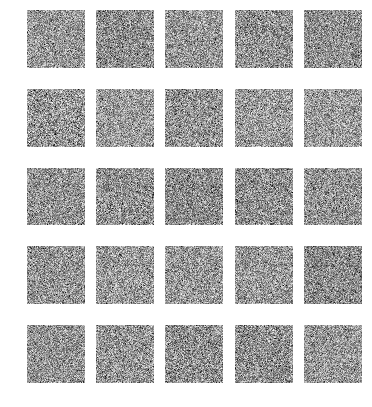

In [178]:
plot_samples(generator_gan_fc, [5,5], (6,7))

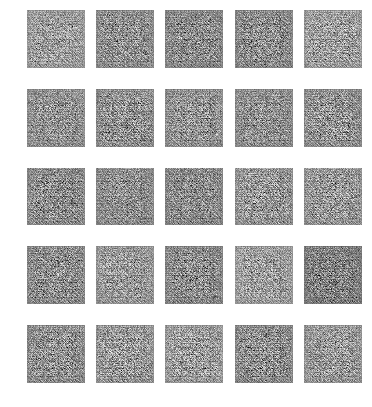

In [179]:
plot_samples(generator_gan_dc, [5,5], (6,7))

### LSGAN

In [180]:
# assign a == 1; b == 0; c == b == 0
def train_lsgan(generator, discriminator, criterion, optim_G, optim_D, sched_G, sched_D):
    ######
    # Create necessary variables
    ######
    input = Variable(torch.FloatTensor(config.batch_size, config.image_size * config.image_size)).cuda()
    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).cuda()
    fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1)).cuda()
    label = Variable(torch.FloatTensor(config.batch_size)).cuda()
    
    a = 1
    b = 0
    c = 0
    
    DISC_ITERS = 1
    GENR_ITERS = 1
    
    try:
        for epoch in range(config.num_epochs):
            #for iteration, (images, cat) in enumerate(dataloader):
            for iteration in xrange(len(dataloader) / DISC_ITERS):
                for sub_iteration in xrange(DISC_ITERS):
                    (images, cat) = next(iter(dataloader))
                    ####### 
                    # Discriminator stage: maximize (D(x) - b)**2 + (D(G(z)) - a)**2 
                    #######
                    discriminator.zero_grad()

                    # real
                    label.data.fill_(b)
                    # only one channal images
                    assert(images.shape[1] == 1)
                    images = images.view(images.shape[0], images.shape[2] * images.shape[3])
                    input.data.copy_(images)
                    
                    output = discriminator(input)
                    output = output.view(output.shape[0])
                    
                    errD_x = criterion(output, label)
                    errD_x.backward()

                    # fake 
                    noise.data.normal_(0, 1)
                    fake = generator(noise)
                    label.data.fill_(a)
                    
                    output = discriminator(fake.detach())
                    output = output.view(output.shape[0])

                    errD_z = criterion(output, label)
                    errD_z.backward()

                    optim_D.step()
                    sched_D.step()

                for sub_iteration in xrange(GENR_ITERS):
                    ####### 
                    # Generator stage: maximize (D(G(x) - c)**2
                    #######
                    generator.zero_grad()
                    fake = generator(noise)
                    label.data.fill_(c)
                    
                    output = discriminator(fake)
                    output = output.view(output.shape[0])

                    errG = criterion(output, label)
                    errG.backward()

                    optim_G.step()
                    sched_G.step()

                if (iteration+1 ) % (config.print_freq / 100) == 0:
                    print('Epoch:{} Iter: {} errD_x: {:.4f} errD_z: {:.4f} errG: {:.4f}'.format(epoch+1, iteration+1, 
                                                                                                errD_x.data[0], errD_z.data[0], 
                                                                                                errG.data[0]))
                    plot_samples(generator, [1,3], (6,7))
                    
#                 if iteration > 1000 or epoch > 1:
#                     if errG.data[0] / errD_z.data[0] > 50:
#                         GENR_ITERS *= 2
#                     elif errD_z.data[0] / errG.data[0] > 50:
#                         DISC_ITERS *= 2
                        
#                     if GENR_ITERS % 2 == 0 and DISC_ITERS % 2 == 0:
#                         GENR_ITERS /= 2
#                         DISC_ITERS /= 2
                        
#                     if  errD_x.data[0] > 0.4:
#                         GENR_ITERS = max(1, GENR_ITERS / 2)

#                     if GENR_ITERS > 8:
#                         GENR_ITERS = 8
#                     if DISC_ITERS > 8:
#                         DISC_ITERS = 8
#                     print DISC_ITERS
#                     print GENR_ITERS
    
    except KeyboardInterrupt:
        pass

In [181]:
generator_lsgan_dc = Generator_DC().cuda()
discriminator_lsgan_dc = Discriminator_DC().cuda()

optim_G_lsgan_dc = optim.Adam(params=generator_lsgan_dc.parameters(), lr=0.0001)
optim_D_lsgan_dc = optim.Adam(params=discriminator_lsgan_dc.parameters(), lr=0.0001)

sched_G_lsgan_dc = StepLR(optim_G_lsgan_dc, step_size=100, gamma=0.999)
sched_D_lsgan_dc = StepLR(optim_D_lsgan_dc, step_size=100, gamma=0.999)

criterion_lsgan_dc = nn.MSELoss().cuda()

In [182]:
# train_lsgan(generator_lsgan_dc, discriminator_lsgan_dc,
#             criterion_lsgan_dc, 
#             optim_G_lsgan_dc, optim_D_lsgan_dc, sched_G_lsgan_dc, sched_D_lsgan_dc)

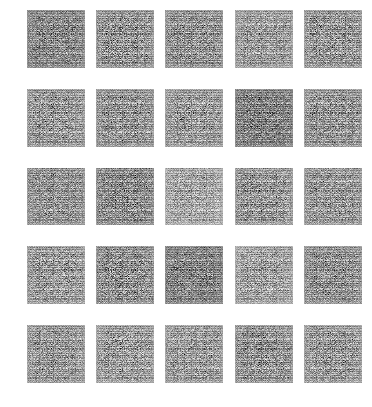

In [183]:
plot_samples(generator_lsgan_dc, [5,5], (6,7))

### WGAN

In [373]:
class Generator_WDC(nn.Module):
    def __init__(self):
        super(Generator_WDC, self).__init__()

        preprocess = nn.Sequential(
            nn.Linear(config.noise_size, 4*4*4*64),
            nn.ReLU(True),
        )
        block1 = nn.Sequential(
            nn.ConvTranspose2d(4*64, 2*64, 5),
            nn.ReLU(True),
        )
        block2 = nn.Sequential(
            nn.ConvTranspose2d(2*64, 64, 5),
            nn.ReLU(True),
        )
        deconv_out = nn.ConvTranspose2d(64, 1, 8, stride=2)

        self.block1 = block1
        self.block2 = block2
        self.deconv_out = deconv_out
        self.preprocess = preprocess
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        output = self.preprocess(input)
        output = output.view(-1, 4*64, 4, 4)
        output = self.block1(output)
        output = output[:, :, :7, :7]
        output = self.block2(output)
        output = self.deconv_out(output)
        output = self.sigmoid(output)
        return output.view(-1, config.image_size * config.image_size)

class Discriminator_WDC(nn.Module):
    def __init__(self):
        super(Discriminator_WDC, self).__init__()

        main = nn.Sequential(
            nn.Conv2d(1, 64, 5, stride=2, padding=2),
            nn.ReLU(True),
            nn.Conv2d(64, 2*64, 5, stride=2, padding=2),
            nn.ReLU(True),
            nn.Conv2d(2*64, 4*64, 5, stride=2, padding=2),
            nn.ReLU(True),
        )
        self.main = main
        self.output = nn.Linear(4*4*4*64, 1)

    def forward(self, input):
        input = input.view(-1, 1, config.image_size, config.image_size)
        out = self.main(input)
        out = out.view(-1, 4*4*4*64)
        out = self.output(out)
        return out.view(-1)

In [391]:
def calc_gradient_penalty(discriminator, real_data, fake_data, constrate_lambda=10.):
    alpha = torch.rand(config.batch_size, 1).cpu()
    alpha = alpha.expand(config.batch_size, config.image_size * config.image_size).contiguous()
    alpha = alpha.view(config.batch_size, 1, config.image_size, config.image_size)
    alpha = alpha.cuda()

    interpolates = alpha * real_data + ((1. - alpha) * fake_data)
    interpolates = autograd.Variable(interpolates, requires_grad=True).cuda()

    disc_interpolates = discriminator(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * constrate_lambda
    return gradient_penalty

def train_wgan(generator, discriminator, optim_G, optim_D, sched_G, sched_D):
    ######
    # Create necessary variables
    ######
    input = Variable(torch.FloatTensor(config.batch_size, config.image_size * config.image_size)).cuda()
    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).cuda()
    fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1)).cuda()
    
    DISC_ITERS = 5
    GENR_ITERS = 1
    
    w_distances = []
    one = torch.FloatTensor([1])
    mone = one * -1
    one = one.cuda()
    mone = mone.cuda()
    
    try:
        for epoch in range(config.num_epochs):
            #for iteration, (images, cat) in enumerate(dataloader):
            for iteration in xrange(len(dataloader)):
                ############################
                # (1) Update D network
                ###########################
                for p in discriminator.parameters():  # reset requires_grad
                    p.requires_grad = True  # they are set to False below in generator update

                for iter_d in xrange(DISC_ITERS):
                    _data, cat = next(iter(dataloader))
                    real_data = torch.Tensor(_data)
                    real_data = real_data.cuda()
                    real_data_v = autograd.Variable(_data).cuda()

                    discriminator.zero_grad()
                    # train with real
                    D_real = discriminator(real_data_v)
                    D_real = D_real.mean()
                    # print D_real
                    D_real.backward(mone)

                    # train with fake
                    noise = torch.randn(config.batch_size, config.noise_size)
                    noise = noise.cuda()
                    noisev = autograd.Variable(noise, volatile=True)  # totally freeze generator
                    fake = autograd.Variable(generator(noisev).data)
                    inputv = fake
                    D_fake = discriminator(inputv)
                    D_fake = D_fake.mean()
                    D_fake.backward(one)

                    # train with gradient penalty
                    gradient_penalty = calc_gradient_penalty(discriminator, real_data_v.data, fake.data)
                    gradient_penalty.backward()

                    D_cost = D_fake - D_real + gradient_penalty
                    w_distances.append((D_real - D_fake).cpu().data[0])
                    optim_D.step()

                ############################
                # (2) Update G network
                ###########################
                for p in discriminator.parameters():
                    p.requires_grad = False  # to avoid computation
                generator.zero_grad()

                noise = torch.randn(config.batch_size, config.noise_size)
                noise = noise.cuda()
                noisev = autograd.Variable(noise)
                fake = generator(noisev)
                G = discriminator(fake)
                G = G.mean()
                G.backward(mone)
                G_cost = -G
                optim_G.step()

#                 for sub_iteration in xrange(DISC_ITERS):
#                     (images, cat) = next(iter(dataloader))
#                     ####### 
#                     # Discriminator stage: maximize M(D(x)) - M(D(G(z)))
#                     #######
#                     discriminator.zero_grad()

#                     # real
#                     # only one channal images
#                     assert(images.shape[1] == 1)
#                     images = images.view(images.shape[0], images.shape[2] * images.shape[3])
#                     input.data.copy_(images)
                    
#                     output_real = discriminator(input)
#                     output_real = output_real.mean()
#                     output_real.backward()

#                     # fake 
#                     noise.data.normal_(0, 1)
#                     fake = generator(noise)
                    
#                     output_fake = discriminator(fake.detach())
#                     output_fake = -output_fake.mean()
#                     output_fake.backward()
                    
#                     gradient_penalty = calc_gradient_penalty(discriminator, input.data, fake.data)
#                     gradient_penalty.backward()
                    
#                     optim_D.step()
#                     sched_D.step()
                    
#                     w_distances.append((output_real.cpu().data - output_fake.cpu().data)[0])

#                 for sub_iteration in xrange(GENR_ITERS):
#                     ####### 
#                     # Generator stage: maximize M(D(G(x)))
#                     #######
#                     generator.zero_grad()
#                     fake = generator(noise)
                    
#                     output = discriminator(fake)
#                     output = output.mean()
#                     output.backward()

#                     optim_G.step()
#                     sched_G.step()

                if (iteration+1 ) % (config.print_freq / 20) == 0:
                    # print('Epoch:{} Iter: {} Wassershtein distance: {:.4f}'.format(epoch+1, iteration+1, w_distances[-1]))
                    print('Epoch:{} Iter: {} Wassershtein distance: {:.4f}'.format(epoch+1, iteration+1, w_distances[-1]))
                    plot_samples(generator, [1,3], (6,7))
    
    except KeyboardInterrupt:
        pass
    plt.plot(w_distances, label='Wassershtein distance')
    plt.legend(fontsize=14)
    plt.show

In [392]:
generator_wgan_dc = Generator_WDC().cuda()
discriminator_wgan_dc = Discriminator_WDC().cuda()

optim_G_wgan_dc = optim.Adam(params=generator_wgan_dc.parameters(), lr=1e-4, betas=(0.5, 0.9))
optim_D_wgan_dc = optim.Adam(params=discriminator_wgan_dc.parameters(), lr=1e-4, betas=(0.5, 0.9))

sched_G_wgan_dc = StepLR(optim_G_wgan_dc, step_size=100, gamma=0.999)
sched_D_wgan_dc = StepLR(optim_D_wgan_dc, step_size=100, gamma=0.999)

Epoch:1 Iter: 10 Wassershtein distance: 73.5070


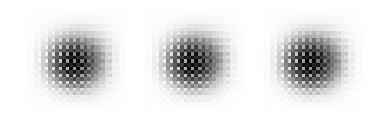

Epoch:1 Iter: 20 Wassershtein distance: 171.2910


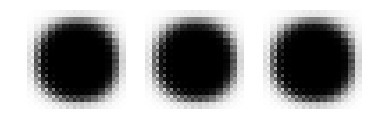

Epoch:1 Iter: 30 Wassershtein distance: 743.4210


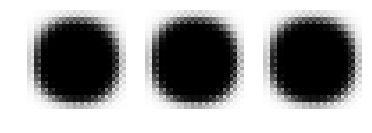

Epoch:1 Iter: 40 Wassershtein distance: 1221.6034


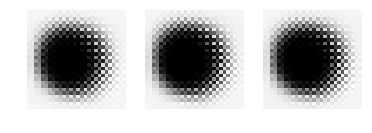

Epoch:1 Iter: 50 Wassershtein distance: 1921.8998


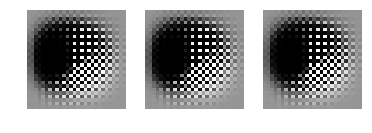

Epoch:1 Iter: 60 Wassershtein distance: 2567.9163


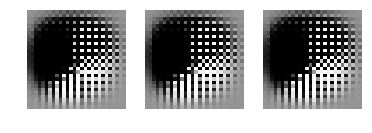

Epoch:1 Iter: 70 Wassershtein distance: 2680.7356


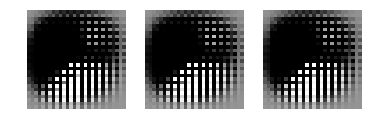

Epoch:1 Iter: 80 Wassershtein distance: 2554.7754


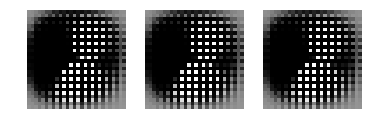

Epoch:1 Iter: 90 Wassershtein distance: 2335.7771


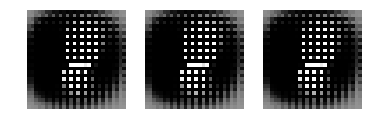

Epoch:1 Iter: 100 Wassershtein distance: 1732.0953


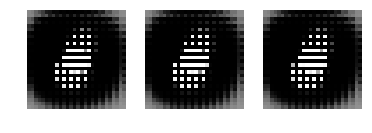

Epoch:1 Iter: 110 Wassershtein distance: 1876.2092


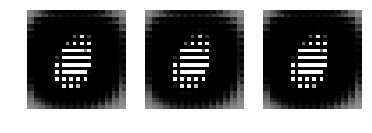

Epoch:1 Iter: 120 Wassershtein distance: 2301.7861


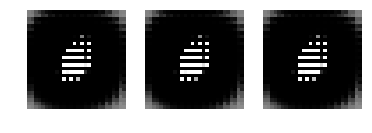

Epoch:1 Iter: 130 Wassershtein distance: 2377.1528


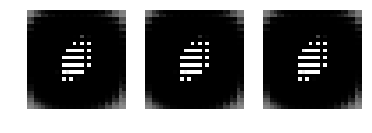

Epoch:1 Iter: 140 Wassershtein distance: 2419.3386


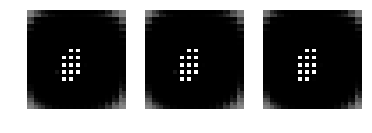

Epoch:1 Iter: 150 Wassershtein distance: 2614.0137


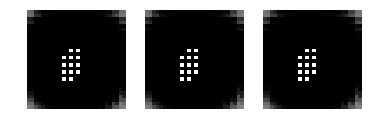

Epoch:1 Iter: 160 Wassershtein distance: 3012.7412


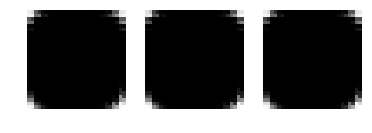

Epoch:1 Iter: 170 Wassershtein distance: 2728.7339


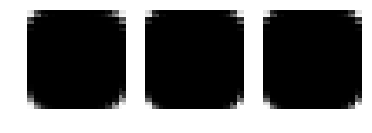

Epoch:1 Iter: 180 Wassershtein distance: 2804.6584


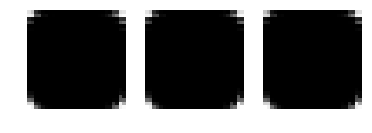

Epoch:1 Iter: 190 Wassershtein distance: 3406.7395


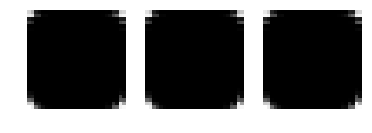

Epoch:1 Iter: 200 Wassershtein distance: 2483.4771


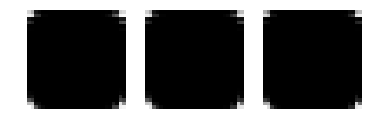

Epoch:1 Iter: 210 Wassershtein distance: 3412.5083


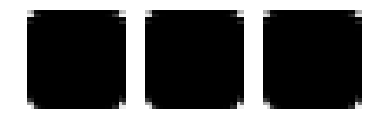

Epoch:1 Iter: 220 Wassershtein distance: 2936.7012


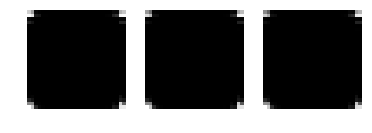

Epoch:1 Iter: 230 Wassershtein distance: 3215.1494


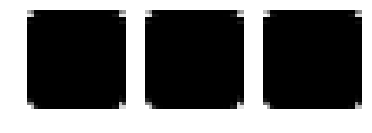

Epoch:1 Iter: 240 Wassershtein distance: 2930.1572


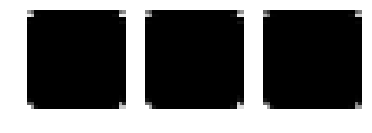

Process Process-74866:
  File "/home/m.nakhodnov/anaconda3/envs/py2.7.14/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 21, in recv
Traceback (most recent call last):
  File "/home/m.nakhodnov/anaconda3/envs/py2.7.14/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/m.nakhodnov/anaconda3/envs/py2.7.14/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/m.nakhodnov/anaconda3/envs/py2.7.14/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/m.nakhodnov/anaconda3/envs/py2.7.14/lib/python2.7/multiprocessing/queues.py", line 376, in get
    return recv()
    buf = self.recv_bytes()
KeyboardInterrupt


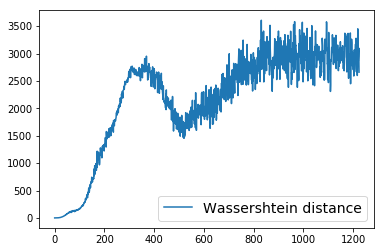

In [393]:
train_wgan(generator_wgan_dc, discriminator_wgan_dc, 
           optim_G_wgan_dc, optim_D_wgan_dc,
           sched_G_wgan_dc, sched_D_wgan_dc)

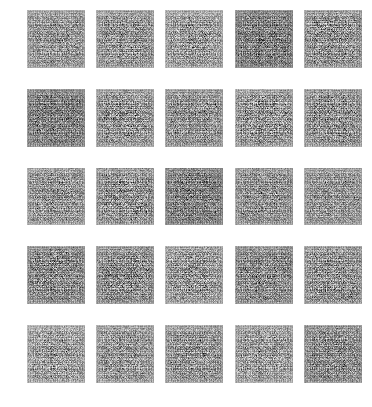

In [153]:
plot_samples(generator_wgan_dc, [5,5], (6,7))